In [1]:
import pandas as pd

In [4]:
x_train = pd.read_csv('store-sales-time-series-forecasting/train.csv')

In [12]:
x_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [36]:
x_train['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [39]:
x_train['store_nbr'].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

In [47]:
store_sales = x_train.set_index('date')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

In [48]:
store_sales.head()

id  sales  onpromotion
date       store_nbr family                            
2013-01-01 1         AUTOMOTIVE   0    0.0            0
                     BABY CARE    1    0.0            0
                     BEAUTY       2    0.0            0
                     BEVERAGES    3    0.0            0
                     BOOKS        4    0.0            0

In [49]:
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390807
2013-01-03    202.840197
2013-01-04    198.911154
2013-01-05    267.873244
Name: sales, dtype: float64

### Time Step Features

In [50]:
df = average_sales.to_frame()
df.head()

,sales
date,
2013-01-01,1.409438
2013-01-02,278.390807
2013-01-03,202.840197
2013-01-04,198.911154
2013-01-05,267.873244


In [52]:
from sklearn.linear_model import LinearRegression

In [55]:
time = np.arange(len(df.index))
df['time'] = time 

In [56]:
df.head()

,sales,time
date,,
2013-01-01,1.409438,0
2013-01-02,278.390807,1
2013-01-03,202.840197,2
2013-01-04,198.911154,3
2013-01-05,267.873244,4


In [57]:
X = df.loc[:, ['time']]  # features
y = df.loc[:, 'sales']  # target

In [58]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [59]:
y_pred = model.predict(X)

In [62]:
y_pred[:10]

array([194.23279017, 194.42713713, 194.62148408, 194.81583103,
       195.01017798, 195.20452493, 195.39887188, 195.59321883,
       195.78756578, 195.98191273])

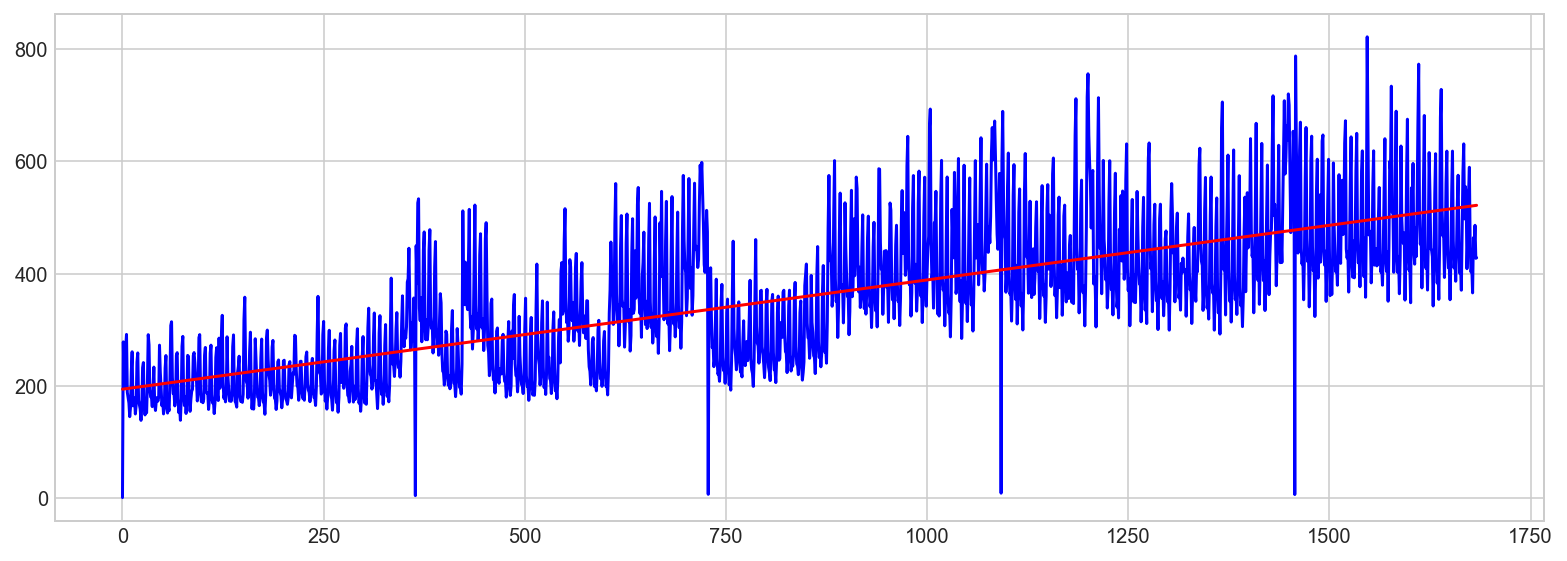

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(X['time'], y, color='blue', label='Actual vs Predicted')
plt.plot(X['time'], y_pred, color='red', label='Actual vs Predicted')

### Lag  Features


In [74]:
lag_1 = df['sales'].shift(1)
df['lag_1'] = lag_1  # add to dataframe

In [75]:
df.head()

,sales,time,lag_1
date,,,
2013-01-01,1.409438,0,NaN
2013-01-02,278.390807,1,1.409438
2013-01-03,202.840197,2,278.390807
2013-01-04,198.911154,3,202.840197
2013-01-05,267.873244,4,198.911154


In [87]:
X = df.loc[:, ['lag_1']].dropna()
y = df.loc[:, 'sales']

In [88]:
y, X = y.align(X, join='inner')

In [91]:
model = LinearRegression()
model.fit(X,y)

LinearRegression()

In [92]:
y_pred = model.predict(X)

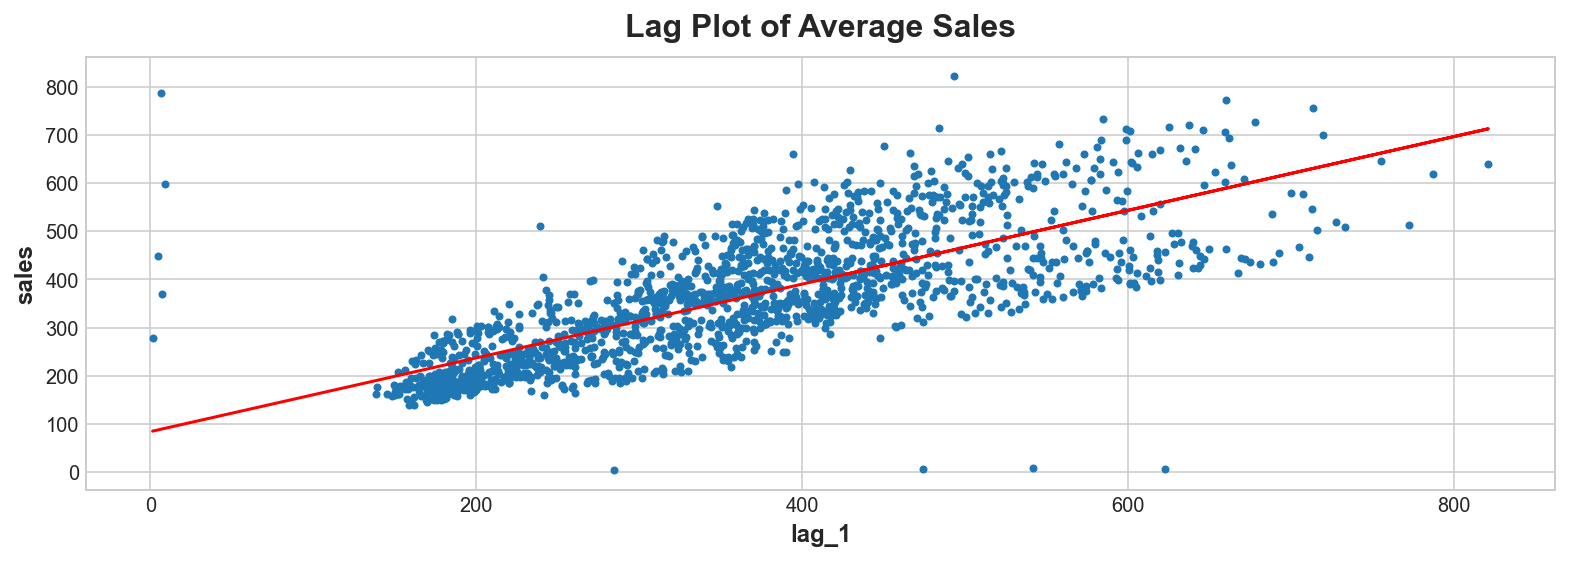

In [101]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.')
ax.plot(X['lag_1'], y_pred, color='red')
ax.set(ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

# Trend